## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [3]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [5]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


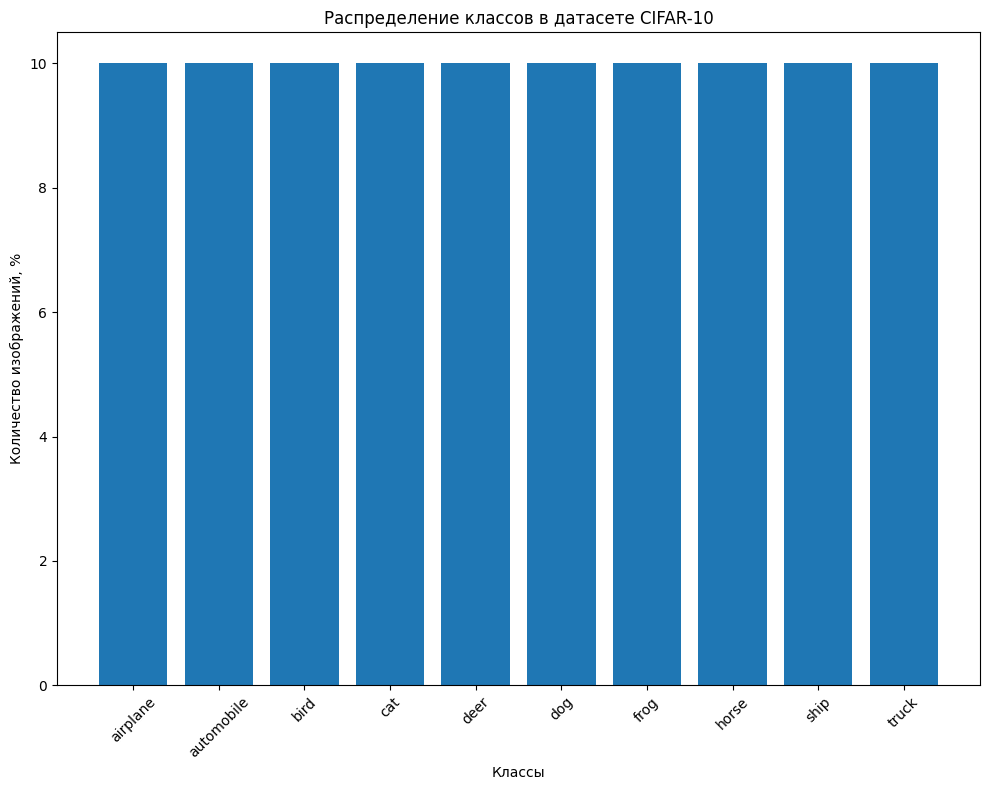

In [6]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Трансформация для тестовых данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

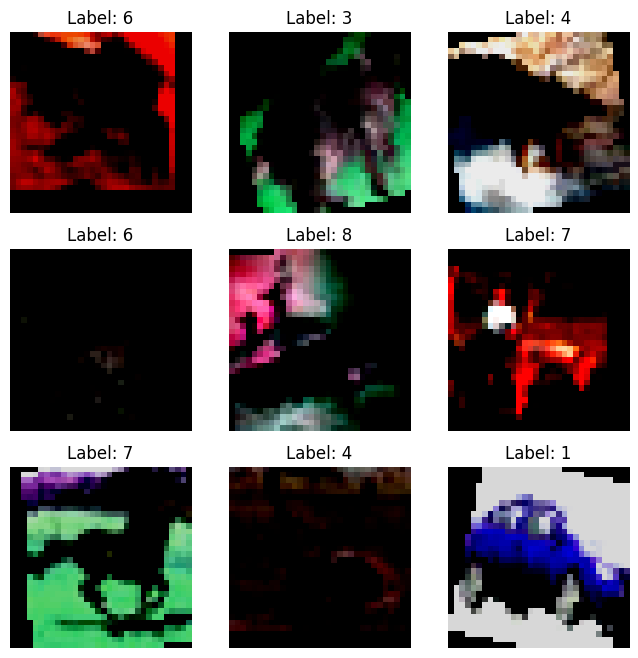

In [7]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc=f'Train epoch {epoch + 1}/{epochs}')
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 'accuracy': f'{correct / total:.4f}'})

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs} -> Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_correct / val_total:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [10]:
learning_rate = 0.001
num_epochs = 30
batch_size = 64

# Модель
model = CustomCNN(num_classes=10)
print('Model params: ', count_parameters(model))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Планировщик обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# DataLoader'ы
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  3064586


Обучите модель и постройте графики обучения

In [ ]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=num_epochs
)


Train epoch 1/30: 100%|█████████████| 625/625 [00:56<00:00, 10.98it/s, loss=1.7243, accuracy=0.3635]


Epoch 1/30 -> Train Loss: 1.7243, Train Acc: 0.3635, Val Loss: 1.3834, Val Acc: 0.4963


Train epoch 2/30: 100%|█████████████| 625/625 [00:54<00:00, 11.52it/s, loss=1.4137, accuracy=0.4830]


Epoch 2/30 -> Train Loss: 1.4137, Train Acc: 0.4830, Val Loss: 1.1804, Val Acc: 0.5785


Train epoch 3/30: 100%|█████████████| 625/625 [00:53<00:00, 11.59it/s, loss=1.2438, accuracy=0.5516]


Epoch 3/30 -> Train Loss: 1.2438, Train Acc: 0.5516, Val Loss: 1.0173, Val Acc: 0.6320


Train epoch 4/30: 100%|█████████████| 625/625 [00:53<00:00, 11.65it/s, loss=1.1302, accuracy=0.5979]


Epoch 4/30 -> Train Loss: 1.1302, Train Acc: 0.5979, Val Loss: 0.9482, Val Acc: 0.6677


Train epoch 5/30: 100%|█████████████| 625/625 [00:53<00:00, 11.62it/s, loss=1.0564, accuracy=0.6260]


Epoch 5/30 -> Train Loss: 1.0564, Train Acc: 0.6260, Val Loss: 0.9087, Val Acc: 0.6802


Train epoch 6/30: 100%|█████████████| 625/625 [00:54<00:00, 11.37it/s, loss=1.0014, accuracy=0.6453]


Epoch 6/30 -> Train Loss: 1.0014, Train Acc: 0.6453, Val Loss: 0.8718, Val Acc: 0.6964


Train epoch 7/30: 100%|█████████████| 625/625 [00:54<00:00, 11.55it/s, loss=0.9453, accuracy=0.6683]


Epoch 7/30 -> Train Loss: 0.9453, Train Acc: 0.6683, Val Loss: 0.8196, Val Acc: 0.7172


Train epoch 8/30: 100%|█████████████| 625/625 [00:54<00:00, 11.49it/s, loss=0.9124, accuracy=0.6795]


Epoch 8/30 -> Train Loss: 0.9124, Train Acc: 0.6795, Val Loss: 0.8483, Val Acc: 0.7058


Train epoch 9/30: 100%|█████████████| 625/625 [00:53<00:00, 11.65it/s, loss=0.8746, accuracy=0.6946]


Epoch 9/30 -> Train Loss: 0.8746, Train Acc: 0.6946, Val Loss: 0.7387, Val Acc: 0.7439


Train epoch 10/30: 100%|████████████| 625/625 [00:54<00:00, 11.40it/s, loss=0.8506, accuracy=0.7026]


Epoch 10/30 -> Train Loss: 0.8506, Train Acc: 0.7026, Val Loss: 0.7365, Val Acc: 0.7428


Train epoch 11/30: 100%|████████████| 625/625 [00:53<00:00, 11.62it/s, loss=0.7538, accuracy=0.7349]


Epoch 11/30 -> Train Loss: 0.7538, Train Acc: 0.7349, Val Loss: 0.7022, Val Acc: 0.7615


Train epoch 12/30: 100%|████████████| 625/625 [00:53<00:00, 11.73it/s, loss=0.7281, accuracy=0.7429]


Epoch 12/30 -> Train Loss: 0.7281, Train Acc: 0.7429, Val Loss: 0.6666, Val Acc: 0.7723


Train epoch 13/30: 100%|████████████| 625/625 [00:53<00:00, 11.69it/s, loss=0.7190, accuracy=0.7505]


Epoch 13/30 -> Train Loss: 0.7190, Train Acc: 0.7505, Val Loss: 0.6444, Val Acc: 0.7774


Train epoch 14/30: 100%|████████████| 625/625 [00:53<00:00, 11.59it/s, loss=0.6953, accuracy=0.7566]


Epoch 14/30 -> Train Loss: 0.6953, Train Acc: 0.7566, Val Loss: 0.6176, Val Acc: 0.7890


Train epoch 15/30: 100%|████████████| 625/625 [00:53<00:00, 11.63it/s, loss=0.6855, accuracy=0.7619]


Epoch 15/30 -> Train Loss: 0.6855, Train Acc: 0.7619, Val Loss: 0.6309, Val Acc: 0.7846


Train epoch 16/30: 100%|████████████| 625/625 [00:53<00:00, 11.73it/s, loss=0.6693, accuracy=0.7655]


Epoch 16/30 -> Train Loss: 0.6693, Train Acc: 0.7655, Val Loss: 0.6189, Val Acc: 0.7950


Train epoch 17/30: 100%|████████████| 625/625 [00:53<00:00, 11.75it/s, loss=0.6545, accuracy=0.7707]


Epoch 17/30 -> Train Loss: 0.6545, Train Acc: 0.7707, Val Loss: 0.5990, Val Acc: 0.7950


Train epoch 18/30: 100%|████████████| 625/625 [00:53<00:00, 11.78it/s, loss=0.6461, accuracy=0.7752]


Epoch 18/30 -> Train Loss: 0.6461, Train Acc: 0.7752, Val Loss: 0.5933, Val Acc: 0.8006


Train epoch 19/30: 100%|████████████| 625/625 [00:53<00:00, 11.62it/s, loss=0.6336, accuracy=0.7795]


Epoch 19/30 -> Train Loss: 0.6336, Train Acc: 0.7795, Val Loss: 0.5917, Val Acc: 0.7984


Train epoch 20/30: 100%|████████████| 625/625 [00:52<00:00, 11.81it/s, loss=0.6232, accuracy=0.7821]


Epoch 20/30 -> Train Loss: 0.6232, Train Acc: 0.7821, Val Loss: 0.6047, Val Acc: 0.7963


Train epoch 21/30: 100%|████████████| 625/625 [00:52<00:00, 11.88it/s, loss=0.5696, accuracy=0.8004]


Epoch 21/30 -> Train Loss: 0.5696, Train Acc: 0.8004, Val Loss: 0.5642, Val Acc: 0.8127


Train epoch 22/30: 100%|████████████| 625/625 [00:53<00:00, 11.71it/s, loss=0.5588, accuracy=0.8043]


Epoch 22/30 -> Train Loss: 0.5588, Train Acc: 0.8043, Val Loss: 0.5395, Val Acc: 0.8209


Train epoch 23/30: 100%|████████████| 625/625 [00:53<00:00, 11.71it/s, loss=0.5468, accuracy=0.8081]


Epoch 23/30 -> Train Loss: 0.5468, Train Acc: 0.8081, Val Loss: 0.5361, Val Acc: 0.8183


Train epoch 24/30: 100%|████████████| 625/625 [00:52<00:00, 11.85it/s, loss=0.5436, accuracy=0.8083]


Epoch 24/30 -> Train Loss: 0.5436, Train Acc: 0.8083, Val Loss: 0.5408, Val Acc: 0.8195


Train epoch 25/30: 100%|████████████| 625/625 [00:53<00:00, 11.78it/s, loss=0.5370, accuracy=0.8119]


Epoch 25/30 -> Train Loss: 0.5370, Train Acc: 0.8119, Val Loss: 0.5364, Val Acc: 0.8188


Train epoch 26/30:  53%|██████▎     | 331/625 [00:28<00:22, 12.80it/s, loss=0.5179, accuracy=0.8187]

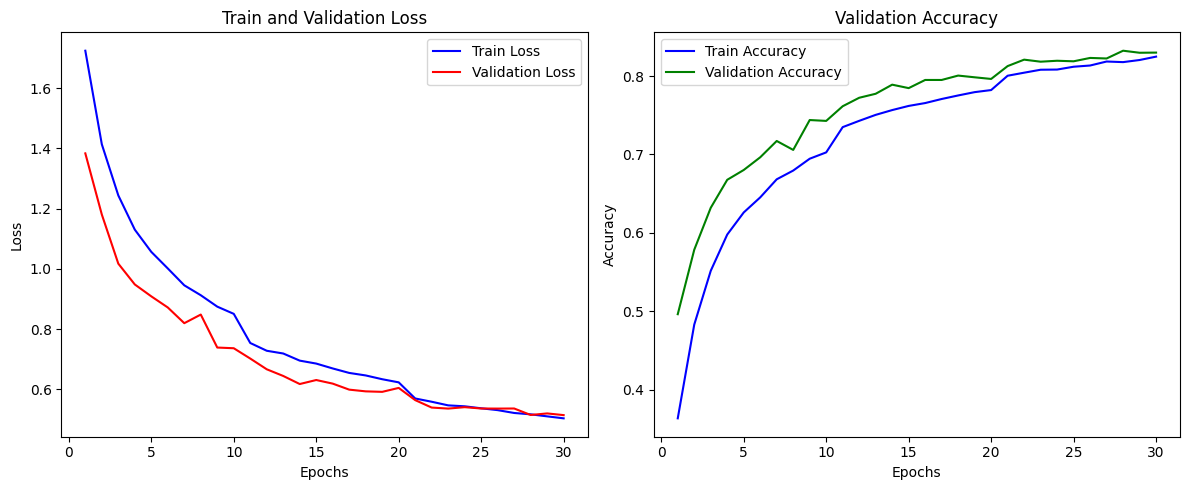

In [12]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [13]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.5144
Test Accuracy: 0.8299


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов